Licensed to the Apache Software Foundation (ASF) under one
or more contributor license agreements.  See the NOTICE file
distributed with this work for additional information
regarding copyright ownership.  The ASF licenses this file
to you under the Apache License, Version 2.0 (the
"License"); you may not use this file except in compliance
with the License.  You may obtain a copy of the License at

  http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing,
software distributed under the License is distributed on an
"AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY
KIND, either express or implied.  See the License for the
specific language governing permissions and limitations
under the License.  

In [ ]:
%matplotlib inline

import sys
import os
import time
import math, cmath
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal


### Generate Noise Spectrum

In [ ]:
def generateNoisyData(f_s, sample_length, SNR, offset=False):
    """
    Create a discrete series of random noise measurements, simulating no drone signal.
    :param f_s: the sampling frequency in Hz
    :param sample_length: the length of the sample in seconds
    :returns: a tuple of time values x, and their corresponding noisy values.
    """
    xs = []
    noisy_ys = []
    A_r = np.random.chisquare(4)
    variance = 10**(2*math.log10(A_r) - (SNR/10))
    for i in range(int(f_s * sample_length)):
        x = i / f_s
        xs.append(x)
        # Generating random noise without incorporating drone signal
        noisy_val = np.random.normal(0, math.sqrt(variance))
        noisy_ys.append(noisy_val)

    return xs, noisy_ys


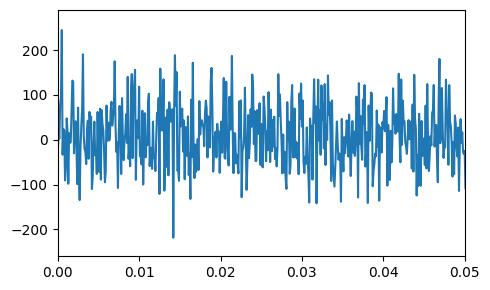

In [ ]:
x, y = generateNoisyData(10_000, 0.4, -30)

fig = plt.figure(figsize=(5.0, 3.0))
ax = fig.add_subplot(111)
ax.set_xlim([0.0, 0.05]) # Zoom on the x-axis to resolve some detail
_ = ax.plot(x, y)
fig.tight_layout()

### Fourier Transform of the Noise Spectrum

In [ ]:
def generateNoisySTFT(f_s, sample_length, SNR):
    xs, noisy_ys = generateNoisyData(f_s, sample_length, SNR)
    f, t, Zreal = signal.stft(
        noisy_ys, f_s, window='hamming', nperseg=32, noverlap=16, return_onesided=True)
    Xreal = 20 * np.log10(np.abs(Zreal))

    xs, noisy_ys = generateNoisyData(f_s, sample_length, SNR)
    f, t, Zimag = signal.stft(
        noisy_ys, f_s, window='hamming', nperseg=32, noverlap=16, return_onesided=True)

    Ximag = 20*np.log10(np.abs(Zimag))

    # Note that we remove the DC component of the transform
    return np.stack((Xreal[1:,:], Ximag[1:,:]))

def generateTwoSidedNoisySTFT(f_s, sample_length, SNR):
    xs, noisy_ys = generateNoisyData(f_s, sample_length, SNR)
    f, t, Zreal = signal.stft(
        noisy_ys, f_s, window='hamming', nperseg=16, noverlap=8, return_onesided=False)
    Xreal = 20 * np.log10(np.abs(Zreal))

    xs, noisy_ys = generateNoisyData(f_s, sample_length, SNR)
    f, t, Zimag = signal.stft(
        noisy_ys, f_s, window='hamming', nperseg=16, noverlap=8, return_onesided=False)

    Ximag = 20*np.log10(np.abs(Zimag))

    # Note that we remove the DC component of the transform
    return np.stack((Xreal, Ximag))

(2, 16, 251)


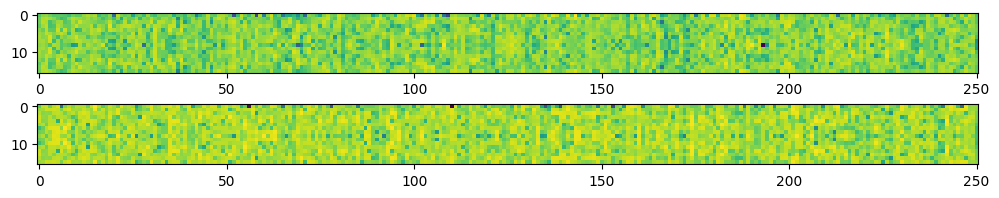

In [ ]:
sp = generateTwoSidedNoisySTFT(10_000, 0.2, 0.0)
print(sp.shape)

fig = plt.figure(figsize=(12.0, 2.0))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
ax1.imshow(sp[0])
ax2.imshow(sp[1])
fig.tight_layout()

### Drone and Radar Parameters

In [ ]:
C = 2.998e8  # speed of light in m/s

scenarioXband= {
    "lamb": 0.02998,  # X band has about a 3 cm wavelength
    "f_c": C/0.02998,
}

djimavicair2 = {
    "name": "DJI_Mavic_Air_2",
    "N": 2,
    "L_1": 0.005,
    "L_2": 0.07,
    # https://mavicpilots.com/threads/mavic-average-rpm.4982/
    "f_rot": 91.66,
}

# taken from my own drone
djimavicmini = {
    "name": "DJI_Mavic_Mini",
    "N": 2,  # two blades per rotor
    "L_1": 0.005,  # 5 mm
    "L_2": 0.035,  # 3.5 cm
    # https://forum.dji.com/thread-214023-1-1.html
    "f_rot": 160,  # 9600 rpm
}

djimatrice300rtk = {
    # https://www.bhphotovideo.com/c/product/1565975-REG/dji_cp_en_00000270_01_matrice_300_series_propeller.html
    "name": "DJI_Matrice_300_RTK",
    "N": 2,  # two blades per rotor
    "L_1": 0.05,
    "L_2": 0.2665,
    "f_rot": 70,  # a guess
}

parrotdisco = {
    # https://www.amazon.com/Parrot-PF070252-Genuine-Disco-Propeller/dp/B01MSMUWW4
    "name": "Parrot_Disco",
    "N": 2,  # two blades per rotor
    "L_1": 0.01,
    "L_2": 0.104,
    "f_rot": 40,  # a guess (lower because rotor isn't used for lift)
}

djiphantom4 = {
    # https://store.dji.com/ca/product/phantom-4-series-low-noise-propellers
    "name": "DJI_Phantom_4",
    "N": 2,  # two blades per rotor
    "L_1": 0.006,
    "L_2": 0.05,
    # https://phantompilots.com/threads/motor-rpm.16886/
    "f_rot": 116,
}

class_map = ["DJI_Matrice_300_RTK", "DJI_Mavic_Air_2",
             "DJI_Mavic_Mini", "DJI_Phantom_4", "Parrot_Disco"]

drones = [djimatrice300rtk, djimavicair2,
          djimavicmini, djiphantom4, parrotdisco]

# For one-sided spectra
#SAMPLE_LENGTH = 0.40 # in seconds
# For two-sided spectra
SAMPLE_LENGTH = 0.20
WF_S = 26_000  # sample frequency for W band, in hz
XF_S = 10_000  # sample frequency for X band, in hz

### Drone Radar Model

In [ ]:

def sinc(x):
    if(x == 0):
        return 1  # this makes it continuous
    return math.sin(x) / x


def paper_sigenerator(f_c, lamb, N, L_1, L_2, f_rot, SNR=None, deterministic=False, **kwargs):
    """
    This function implements the drone radar return model as used in the paper "Detecting
    drones with radars and convolutional networks based on mico-Doppler signatures"
    :param f_c: Sampling frequency of the radar return signal
    :param lamb: Wavelength of the transmitted radar signal
    :param N: Number of rotating blades
    :param L_1: Distance to the blade roots to the centre of rotation
    :param L_2: Distance to  the blade tips from the centre of rotation
    :param f_rot: Frequency of rotation of rotating blades
    :param SNR: Signal-to-noise ratio, given in dB. If None, don't add noise
    :param deterministic: Use known model parameter values rather than randomly selected one
    """
    if deterministic is True:
        A_r = 5
        R = 1000
        theta = np.pi/4
        phi_p = np.pi/8
        V_rad = 20

    else:
        A_r = np.random.chisquare(4)  # A_r is a random value from X^2 with 4 dof
        R = np.random.uniform(low=200, high=2000)
        theta = np.random.uniform(low=np.pi/16, high=np.pi/2)
        phi_p = np.random.uniform(low=0, high=np.pi/4)
        V_rad = np.random.uniform(low=0, high=50)
        #V_rad = 0.0

    def psi(t):
        abs_theta = np.abs(theta)
        alpha = np.sin(abs_theta + phi_p) + np.sin(abs_theta - phi_p)
        beta = np.sign(theta) * (np.sin(abs_theta + phi_p) - np.sin(abs_theta - phi_p))
        wavelength_term = 4 * np.pi / lamb
        prefactor = A_r * cmath.exp(1j*(2*math.pi*f_c*t - wavelength_term*(R+V_rad*t)))

        accum = complex(0, 0)
        for n in range(N):
            omega_n = 2 * np.pi * np.add.outer(f_rot * t, n / N)
            alpha_beta_term = alpha + beta * np.cos(omega_n)
            cos_sin_term = np.cos(theta) * np.sin(omega_n)
            # The original 'sinc' term appears to be in error. It shouldn't be
            # divided by a factor of pi.
            #
            # sinc_term = np.sinc(
            #    (wavelength_term * 0.5 * (L_2 - L_1) * cos_sin_term) / np.pi)
            sinc_term = np.sinc(
                (wavelength_term * 0.5 * (L_2 - L_1) * cos_sin_term)
            )
            # The original 'exp2_term' also appears to be in error. There should be no
            # 'cos_sin_term' in the exponential.
            #
            # exp2_term = np.exp(-1j * wavelength_term * ((L_1 + L_2) * 0.5 * cos_sin_term))
            exp2_term = np.exp(-1j * wavelength_term * cos_sin_term * ((L_1 + L_2) * 0.5))
            accum = alpha_beta_term * exp2_term * sinc_term

        # complete signal without A_r scaling, E.49
        psi_mm = prefactor * accum
        return A_r * psi_mm

    if SNR is not None:
        # this is a re-arrangement of dB = 10\log_{10}{A_r^2/\sigma^2}
        variance = 10**(2*math.log10(A_r) - (SNR/10))

        def fuzzypsi(t):
            real_noise = np.random.normal(0, math.sqrt(variance))
            imag_noise = np.random.normal(0, math.sqrt(variance))
            return psi(t) + real_noise + (imag_noise * 1j)

        return fuzzypsi
    else:
        return psi


def psigenerator(f_c, lamb, N, L_1, L_2, f_rot, SNR=None, deterministic=False, **kwargs):
    """
    This function returns a psi function, which represents the RADAR signal off
    of a drone.
    :param f_c: Sampling frequency of the radar return signal
    :param lamb: Wavelength of the transmitted radar signal
    :param N: Number of rotating blades
    :param L_1: Distance to the blade roots to the centre of rotation
    :param L_2: Distance to  the blade tips from the centre of rotation
    :param f_rot: Frequency of rotation of rotating blades
    :param SNR: Signal-to-noise ratio, given in dB. If None, don't add noise
    :param deterministic: Use known model parameter values rather than randomly selected ones
    """

    if deterministic:
        A_r = 1
        R = 0
        theta = 0
        V_rad = 0

    else:
        A_r = np.random.chisquare(4)  # A_r is a random value from X^2 with 4 dof
        R = np.random.uniform(low=1000, high=5000)
        theta = np.random.uniform(low=0, high=np.pi/2)
        V_rad = 0

    def psi(t):
        prefactor = A_r * \
            cmath.exp(1j*(2*math.pi*f_c*t - (4*math.pi/lamb)*(R+V_rad*t)))
        # prefactor = 1  # as suggested in https://discord.com/channels/760673053695934495/794667756132761610/799474019308404786
        accum = complex(0, 0)
        for n in range(N):
            exponential = cmath.exp(-1j*(4*math.pi/lamb)*(((L_1 + L_2)/2) *
                                                         math.cos(theta)*math.sin(2*math.pi*f_rot*t + (2*math.pi*n)/N)))
            sincterm = sinc(((4*math.pi)/lamb)*((L_2 - L_1)/2) *
                            math.cos(theta)*math.sin(2*math.pi*(f_rot*t+(n/N))))
            accum += exponential*sincterm

        return prefactor * accum

    if SNR is not None:
        # this is a re-arrangement of dB = 10\log_{10}{A_r^2/\sigma^2}
        variance = 10**(2*math.log10(A_r) - (SNR/10))

        def fuzzypsi(t):
            real_noise = np.random.normal(0, math.sqrt(variance))
            imag_noise = np.random.normal(0, math.sqrt(variance))
            return psi(t) + real_noise + (imag_noise * 1j)

        return fuzzypsi

    else:  # if we don't want noise, just return psi
        return psi


### Generate and Plot Some Drone Radar Spectra

In [ ]:
# Generate and plot some drone spectra

def plot_drone_signal(drone_model_fn, drone_params, deterministic=False, SNR=None):
    xs = []
    real_ys = []
    imaginary_ys = []

    drone_signal_fn = drone_model_fn(**dict(scenarioXband, **drone_params),
                                     deterministic=deterministic, SNR=SNR)

    xs = np.array([i/XF_S for i in range(int(XF_S * SAMPLE_LENGTH))])
    sig = np.array([drone_signal_fn(x) for x in xs])

    fig = plt.figure(figsize=(10.0, 3.0))
    fig.suptitle(drone_params['name'])
    ax1 = fig.add_subplot(121)
    ax1.set_title("Real")
    ax1.set_xlim([0.0, 0.05]) # Zoom on the x-axis to resolve some detail
    ax1.plot(xs, sig.real)
    ax2 = fig.add_subplot(122)
    ax2.set_title("Imag.")
    ax2.set_xlim([0.0, 0.05]) # Zoom on the x-axis to resolve some detail
    ax2.plot(xs, sig.imag)
    fig.tight_layout()

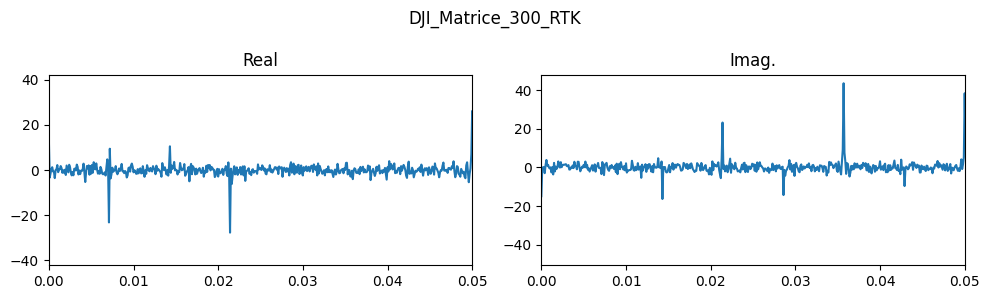

In [ ]:
plot_drone_signal(paper_sigenerator, drones[0], SNR=10, deterministic=True)

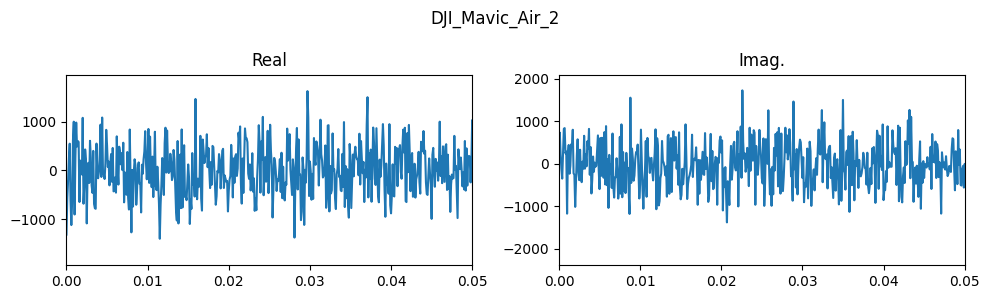

In [ ]:
plot_drone_signal(paper_sigenerator, drones[1], SNR=-35)

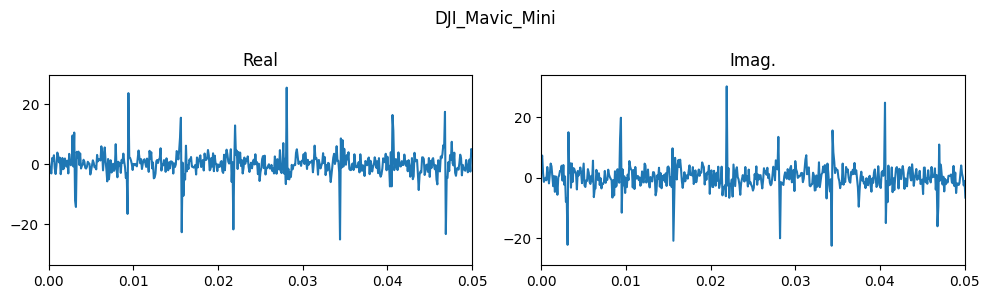

In [ ]:
plot_drone_signal(paper_sigenerator, drones[2], SNR=5)

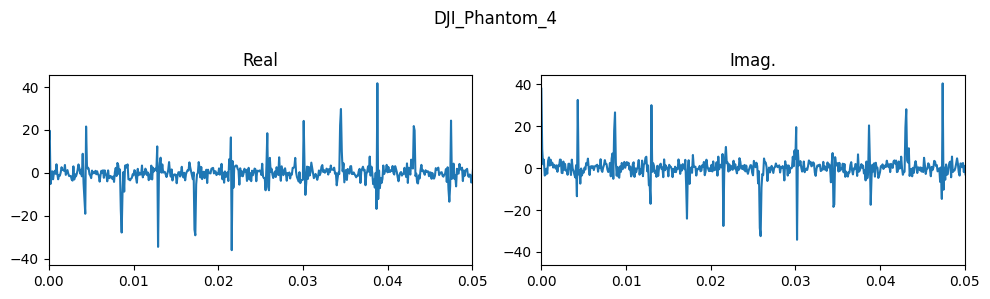

In [ ]:
plot_drone_signal(paper_sigenerator, drones[3], deterministic=False, SNR=10)

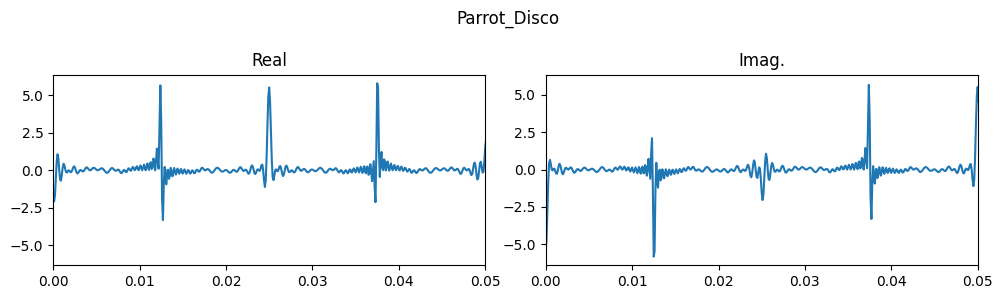

In [ ]:
plot_drone_signal(paper_sigenerator, drones[4])

### Fourier Transform of the Drone Spectra

In [ ]:
def generateData(drone_signal_fn, f_s, sample_length, offset=False):
    xs = []
    real_ys = []
    imaginary_ys = []

    xs = np.array([i/XF_S for i in range(int(XF_S * sample_length))])
    if offset:
        # offset a sample anywhere from 0 to 1 seconds
        offset_val = np.random.uniform(0, 1)
        xs += offset_val
    sig = np.array([drone_signal_fn(x) for x in xs])
    return xs, sig

def generateSTFT(drone_signal_fn, f_s, sample_length, offset=False):

    xs, sig = generateData(drone_signal_fn, f_s, sample_length, offset=offset)

    f, t, Zreal = signal.stft(
        sig.real, f_s, window='hamming', nperseg=32, noverlap=16, return_onesided=True)
    Xreal = 20*np.log10(np.abs(Zreal))

    f, t, Zimag = signal.stft(
        sig.imag, f_s, window='hamming', nperseg=32, noverlap=16, return_onesided=True)
    Ximag = 20*np.log10(np.abs(Zimag))

    # Note that the DC fourier component is removed
    return np.stack((Xreal[1:,:], Ximag[1:,:]))

def generateTwoSidedSTFT(drone_signal_fn, f_s, sample_length, offset=False):

    xs, sig = generateData(drone_signal_fn, f_s, sample_length, offset=offset)

    f, t, Zreal = signal.stft(
        sig.real, f_s, window='hamming', nperseg=16, noverlap=8, return_onesided=False)
    Xreal = 20*np.log10(np.abs(Zreal))

    f, t, Zimag = signal.stft(
        sig.imag, f_s, window='hamming', nperseg=16, noverlap=8, return_onesided=False)
    Ximag = 20*np.log10(np.abs(Zimag))

    # Note that the DC fourier component is removed
    return np.stack((Xreal, Ximag))

def plot_drone_spectrogram(drone_model_fn, drone_params, deterministic=False, SNR=None):
    signal_fn = drone_model_fn(**dict(scenarioXband, **drone_params),
                               deterministic=deterministic, SNR=SNR)
    spect = generateSTFT(signal_fn, XF_S, SAMPLE_LENGTH, offset=False)

    fig = plt.figure(figsize=(10.0, 3.0))
    fig.suptitle(drone_params['name'])
    ax1 = fig.add_subplot(211)
    ax1.set_title("Real")
    ax1.imshow(spect[0])
    ax2 = fig.add_subplot(212)
    ax2.set_title("Imag.")
    ax2.imshow(spect[1])
    fig.tight_layout()

def plot_drone_twosided_spectrogram(drone_model_fn, drone_params, deterministic=False, SNR=None):
    signal_fn = drone_model_fn(**dict(scenarioXband, **drone_params),
                               deterministic=deterministic, SNR=SNR)
    spect = generateTwoSidedSTFT(signal_fn, XF_S, SAMPLE_LENGTH, offset=False)
    print(f"{spect.shape=}")

    fig = plt.figure(figsize=(10.0, 3.0))
    fig.suptitle(drone_params['name'])
    ax1 = fig.add_subplot(211)
    ax1.set_title("Real")
    ax1.imshow(spect[0])
    ax2 = fig.add_subplot(212)
    ax2.set_title("Imag.")
    ax2.imshow(spect[1])
    fig.tight_layout()

spect.shape=(2, 16, 251)


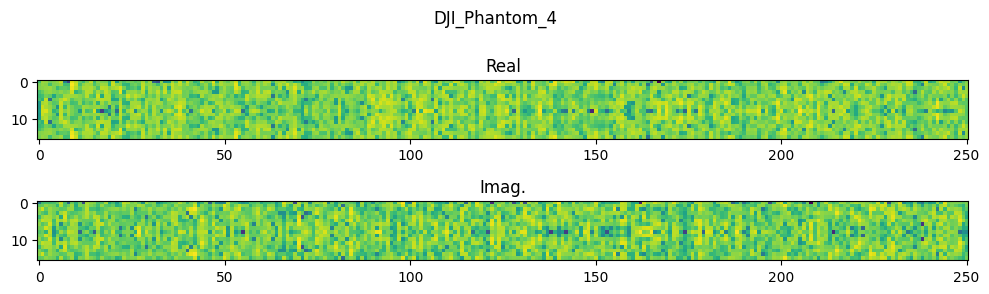

In [ ]:
plot_drone_twosided_spectrogram(paper_sigenerator, drones[3], deterministic=False, SNR=0)

### Generate Datasets

In [ ]:
USING_COLAB = True
try:
    from google.colab import drive
    drive.mount('/content/drive')
except ModuleNotFoundError:
    USING_COLAB = False

if USING_COLAB is True:
    radar_path = "/content/drive/MyDrive/Radar"
else:
    radar_path = "Radar"
if radar_path not in sys.path:
    sys.path.insert(0, radar_path)


### Generate Drone Classification Datasets

In [ ]:
data_dir = "two_sided"

start = time.perf_counter()
drone_model_fn = paper_sigenerator
# The following is 'our' drone model fn:
# drone_model_fn = psigenerator
scenario = scenarioXband
f_s = XF_S
SNRs = [20, 15, 10, 5, 0, -5]
testset_size = 1000
trainset_size = 1000

for SNR in SNRs:
    for drone in drones:

        print(drone["name"])

        # make the directory
        os.system(f"mkdir -p {radar_path}/{data_dir}/testset/{f_s}fs/{SNR}SNR/{drone['name']}")
        print(f"Generating test data for {f_s=}, {SNR=}, {drone['name']=}")
        for x in range(testset_size):
            p = drone_model_fn(**dict(scenario, **drone), SNR=SNR)
            STFT = generateTwoSidedSTFT(p, f_s, SAMPLE_LENGTH, offset=True)
            np.save(f"{radar_path}/{data_dir}/testset/{f_s}fs/{SNR}SNR/{drone['name']}/{x:06}.npy", STFT)

        os.system(f"mkdir -p {radar_path}/{data_dir}/trainset/{f_s}fs/{SNR}SNR/{drone['name']}")
        print(f"Generating training data for {f_s=}, {SNR=}, {drone['name']=}")
        for x in range(trainset_size):
            p = drone_model_fn(**dict(scenario, **drone), SNR=SNR)
            STFT = generateTwoSidedSTFT(p, f_s, SAMPLE_LENGTH, offset=True)
            np.save(f"{radar_path}/{data_dir}/trainset/{f_s}fs/{SNR}SNR/{drone['name']}/{x:06}.npy", STFT)

end = time.perf_counter()
print(f"Execution time: {end - start:0.4f} seconds")

### Generate Drone Detection Datasets

In [ ]:
#data_dir = "binary/two_sided"
data_dir = "binary/two_sided_large"

start = time.perf_counter()
drone_model_fn = paper_sigenerator
# The following is 'our' drone model fn:
# drone_model_fn = psigenerator
scenario = scenarioXband
f_s = XF_S
SNRs = [20, 15, 10, 5, 0, -5, -10, -15, -20]
testset_size = 1000
trainset_size = 2000

for SNR in SNRs:
    for drone in drones:

        print(drone["name"])

        # make the directory
        os.system(f"mkdir -p {radar_path}/{data_dir}/testset/{f_s}fs/{SNR}SNR/drones/{drone['name']}")
        print(f"Generating drone test data for {f_s=}, {SNR=}, {drone['name']=}")
        for x in range(testset_size):
            # new signal function every time
            p = drone_model_fn(**dict(scenario, **drone), SNR=SNR)
            STFT = generateTwoSidedSTFT(p, f_s, SAMPLE_LENGTH, offset=True)
            np.save(f"{radar_path}/{data_dir}/testset/{f_s}fs/{SNR}SNR/drones/{drone['name']}/{x:06}.npy", STFT)

        os.system(f"mkdir -p {radar_path}/{data_dir}/trainset/{f_s}fs/{SNR}SNR/drones/{drone['name']}")
        print(f"Generating drone training data for {f_s=}, {SNR=}, {drone['name']=}")
        for x in range(trainset_size):
            p = drone_model_fn(**dict(scenario, **drone), SNR=SNR)
            STFT = generateTwoSidedSTFT(p, f_s, SAMPLE_LENGTH, offset=True)
            np.save(f"{radar_path}/{data_dir}/trainset/{f_s}fs/{SNR}SNR/drones/{drone['name']}/{x:06}.npy", STFT)

for SNR in SNRs:
    os.system(f"mkdir -p {radar_path}/{data_dir}/testset/{f_s}fs/{SNR}SNR/noise")
    print(f"Generating noise test data for {f_s=}, {SNR=}")
    for x in range(testset_size * len(drones)):
        # new signal function every time
        noisy_STFT = generateTwoSidedNoisySTFT(f_s, SAMPLE_LENGTH, SNR)
        np.save(f"{radar_path}/{data_dir}/testset/{f_s}fs/{SNR}SNR/noise/{x:06}.npy", noisy_STFT)

    os.system(f"mkdir -p {radar_path}/{data_dir}/trainset/{f_s}fs/{SNR}SNR/noise")
    print(f"Generating noise training data for {f_s=}, {SNR=}")
    for x in range(trainset_size * len(drones)):
        noisy_STFT = generateTwoSidedNoisySTFT(f_s, SAMPLE_LENGTH, SNR)
        np.save(f"{radar_path}/{data_dir}/trainset/{f_s}fs/{SNR}SNR/noise/{x:06}.npy", noisy_STFT)

end = time.perf_counter()
print(f"Execution time: {end - start:0.4f} seconds")

DJI_Matrice_300_RTK
Generating drone test data for f_s=10000, SNR=20, drone['name']='DJI_Matrice_300_RTK'
Generating drone training data for f_s=10000, SNR=20, drone['name']='DJI_Matrice_300_RTK'
DJI_Mavic_Air_2
Generating drone test data for f_s=10000, SNR=20, drone['name']='DJI_Mavic_Air_2'
Generating drone training data for f_s=10000, SNR=20, drone['name']='DJI_Mavic_Air_2'
DJI_Mavic_Mini
Generating drone test data for f_s=10000, SNR=20, drone['name']='DJI_Mavic_Mini'
Generating drone training data for f_s=10000, SNR=20, drone['name']='DJI_Mavic_Mini'
DJI_Phantom_4
Generating drone test data for f_s=10000, SNR=20, drone['name']='DJI_Phantom_4'
Generating drone training data for f_s=10000, SNR=20, drone['name']='DJI_Phantom_4'
Parrot_Disco
Generating drone test data for f_s=10000, SNR=20, drone['name']='Parrot_Disco'
Generating drone training data for f_s=10000, SNR=20, drone['name']='Parrot_Disco'
DJI_Matrice_300_RTK
Generating drone test data for f_s=10000, SNR=15, drone['name']='D

### Generate Binary Test Datasets For Model Statistics

In [ ]:
data_dir = "test_sets/binary/two_sided"

drone_model_fn = paper_sigenerator
# The following is 'our' drone model fn:
# drone_model_fn = psigenerator
scenario = scenarioXband
f_s = XF_S
SNRs = [20, 15, 10, 5, 0, -5, -10, -15, -20]
datasets = 5
testset_size = 400

for set in range(datasets):
    print(f"Test data set {set}")
    start = time.perf_counter()
    for SNR in SNRs:
        for drone in drones:

            print(f"  {drone['name']}")

            os.system(f"mkdir -p {radar_path}/{data_dir}/testset_{set}/{f_s}fs/{SNR}SNR/drones/{drone['name']}")
            print(f"    Generating drone test data for {f_s=}, {SNR=}, {drone['name']=}")
            for x in range(testset_size):
                # new signal function every time
                p = drone_model_fn(**dict(scenario, **drone), SNR=SNR)
                STFT = generateTwoSidedSTFT(p, f_s, SAMPLE_LENGTH, offset=True)
                np.save(f"{radar_path}/{data_dir}/testset_{set}/{f_s}fs/{SNR}SNR/drones/{drone['name']}/{x:06}.npy", STFT)


    for SNR in SNRs:
        os.system(f"mkdir -p {radar_path}/{data_dir}/testset_{set}/{f_s}fs/{SNR}SNR/noise")
        print(f"  Generating noise test data for {f_s=}, {SNR=}")
        for x in range(testset_size * len(drones)):
            # new signal function every time
            noisy_STFT = generateTwoSidedNoisySTFT(f_s, SAMPLE_LENGTH, SNR)
            np.save(f"{radar_path}/{data_dir}/testset_{set}/{f_s}fs/{SNR}SNR/noise/{x:06}.npy", noisy_STFT)

    end = time.perf_counter()
    print(f"Execution time: {end - start:0.4f} seconds")

### Generate Classification Test Datasets For Model Statistics

In [ ]:
data_dir = "test_sets/two_sided"

start = time.perf_counter()
drone_model_fn = paper_sigenerator
# The following is 'our' drone model fn:
# drone_model_fn = psigenerator
scenario = scenarioXband
f_s = XF_S
SNRs = [20, 15, 10, 5, 0, -5]
datasets = 5
testset_size = 400
trainset_size = 1000


for set in range(datasets):
    for SNR in SNRs:
        for drone in drones:

            print(drone["name"])

            # make the directory
            os.system(f"mkdir -p {radar_path}/{data_dir}/testset_{set}/{f_s}fs/{SNR}SNR/{drone['name']}")
            print(f"Generating test data for {f_s=}, {SNR=}, {drone['name']=}")
            for x in range(testset_size):
                p = drone_model_fn(**dict(scenario, **drone), SNR=SNR)
                STFT = generateTwoSidedSTFT(p, f_s, SAMPLE_LENGTH, offset=True)
                np.save(f"{radar_path}/{data_dir}/testset_{set}/{f_s}fs/{SNR}SNR/{drone['name']}/{x:06}.npy", STFT)


end = time.perf_counter()
print(f"Execution time: {end - start:0.4f} seconds")